In [64]:
import os
import requests
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

from opensea import OpenseaAPI

plt.style.use('fivethirtyeight')

In [65]:
# Get the current working directory and construct the .env file path
cwd = os.getcwd()
env_file_path = os.path.join(cwd, '.env')

# Load the .env file
load_dotenv(env_file_path)

api_key = os.environ['OPENSEA_API_KEY']
wallet_address = os.environ['WALLET_ADDRESS']

In [66]:
api = OpenseaAPI(apikey=api_key)

owner_address = wallet_address
collections = api.collections(asset_owner=owner_address)

In [67]:
owner_stats = []

# Loop through collections and fetch stats
for collection in collections:
    collection_slug = collection['slug']
    collection_name = collection['name']
    owned_asset_count = collection['owned_asset_count']
    stats = api.collection_stats(collection_slug)
    
    # Check if the 'stats' key is present in the response
    if 'stats' in stats:
        floor_price = stats['stats'].get('floor_price', 'Not available')
    else:
        floor_price = 'Not available'
    
    collection_stats = {
        "name": collection_name,
        "slug": collection_slug,
        "owned_asset_count": owned_asset_count,
        "floor_price": floor_price,
        "stats": stats
    }
    
    owner_stats.append(collection_stats)

# with open('owner_stats.json', 'w') as f:
#     json.dump(owner_stats, f, indent=4)

In [68]:
# Create a dataframe from the owner_stats list
df = pd.DataFrame(owner_stats, columns=[
    'name',
    'owned_asset_count', 
    'floor_price'
])

df.columns = [
    'Collection Name', 
    'Number of Owned NFTs', 
    'Floor Price'
]

df

,Collection Name,Number of Owned NFTs,Floor Price
0,TheBenMeadows On-Chain,1,None
1,genPepes,2,5.0
2,Ralph Lauren x Poolsuite | Miami Awaits,1,None
3,Good Morning Cafe: Keekusaurs,8,0.03
4,THE MAZE by TAYLOR,1,0.008
...,...,...,...
212,Foundation (FND),1,Not available
213,Rarible,5,Not available
214,ENS: Ethereum Name Service,20,Not available
215,SuperRare,2,Not available


In [69]:
# Filter the dataframe to remove nfts with null floor price 
df_filtered = df[(df['Floor Price'] != 'Not available') & pd.notna(df['Floor Price'])].copy()

df_filtered

,Collection Name,Number of Owned NFTs,Floor Price
1,genPepes,2,5.0
3,Good Morning Cafe: Keekusaurs,8,0.03
4,THE MAZE by TAYLOR,1,0.008
5,taylor's editions,1,0.0035
6,Fourscore,1,0.03
...,...,...,...
119,Weeble Wowbles 1/1,1,0.15
120,Silk Road by Ezra Miller,2,0.128
121,Wolf Game - Merch,1,0.0145
151,Forever Rugs,21,0.0097


In [70]:
# Filter the dataframe to further remove nfts that are dust or has value less than 5$ 
df_remove_dust = df_filtered[(df_filtered['Floor Price'].astype(float) >= 0.003)].copy() 

In [71]:
df_remove_dust.head(10)

,Collection Name,Number of Owned NFTs,Floor Price
1,genPepes,2,5.0
3,Good Morning Cafe: Keekusaurs,8,0.03
4,THE MAZE by TAYLOR,1,0.008
5,taylor's editions,1,0.0035
6,Fourscore,1,0.03
7,Meme Lab by 6529,1,0.004995
8,YON EDITIONS,1,0.005
9,Panorama Landscapes by Godwits,2,0.01
12,neurocolor Open Editions,1,0.02666
13,ArtvisionNFT Editions,1,0.05


In [80]:
# Extract required data for the plot
collection_names = df_remove_dust['Collection Name']
nft_counts = df_remove_dust['Number of Owned NFTs']
floor_prices = df_remove_dust['Floor Price']

# Calculate total value of NFTs in the wallet
df_remove_dust['Total Value'] = df_remove_dust['Number of Owned NFTs'] * df_remove_dust['Floor Price']
total_value_wallet = df_remove_dust['Total Value'].sum()

df_remove_dust.head(10)

,Collection Name,Number of Owned NFTs,Floor Price,Total Value
1,genPepes,2,5.0,10.0
3,Good Morning Cafe: Keekusaurs,8,0.03,0.24
4,THE MAZE by TAYLOR,1,0.008,0.008
5,taylor's editions,1,0.0035,0.0035
6,Fourscore,1,0.03,0.03
7,Meme Lab by 6529,1,0.004995,0.004995
8,YON EDITIONS,1,0.005,0.005
9,Panorama Landscapes by Godwits,2,0.01,0.02
12,neurocolor Open Editions,1,0.02666,0.02666
13,ArtvisionNFT Editions,1,0.05,0.05


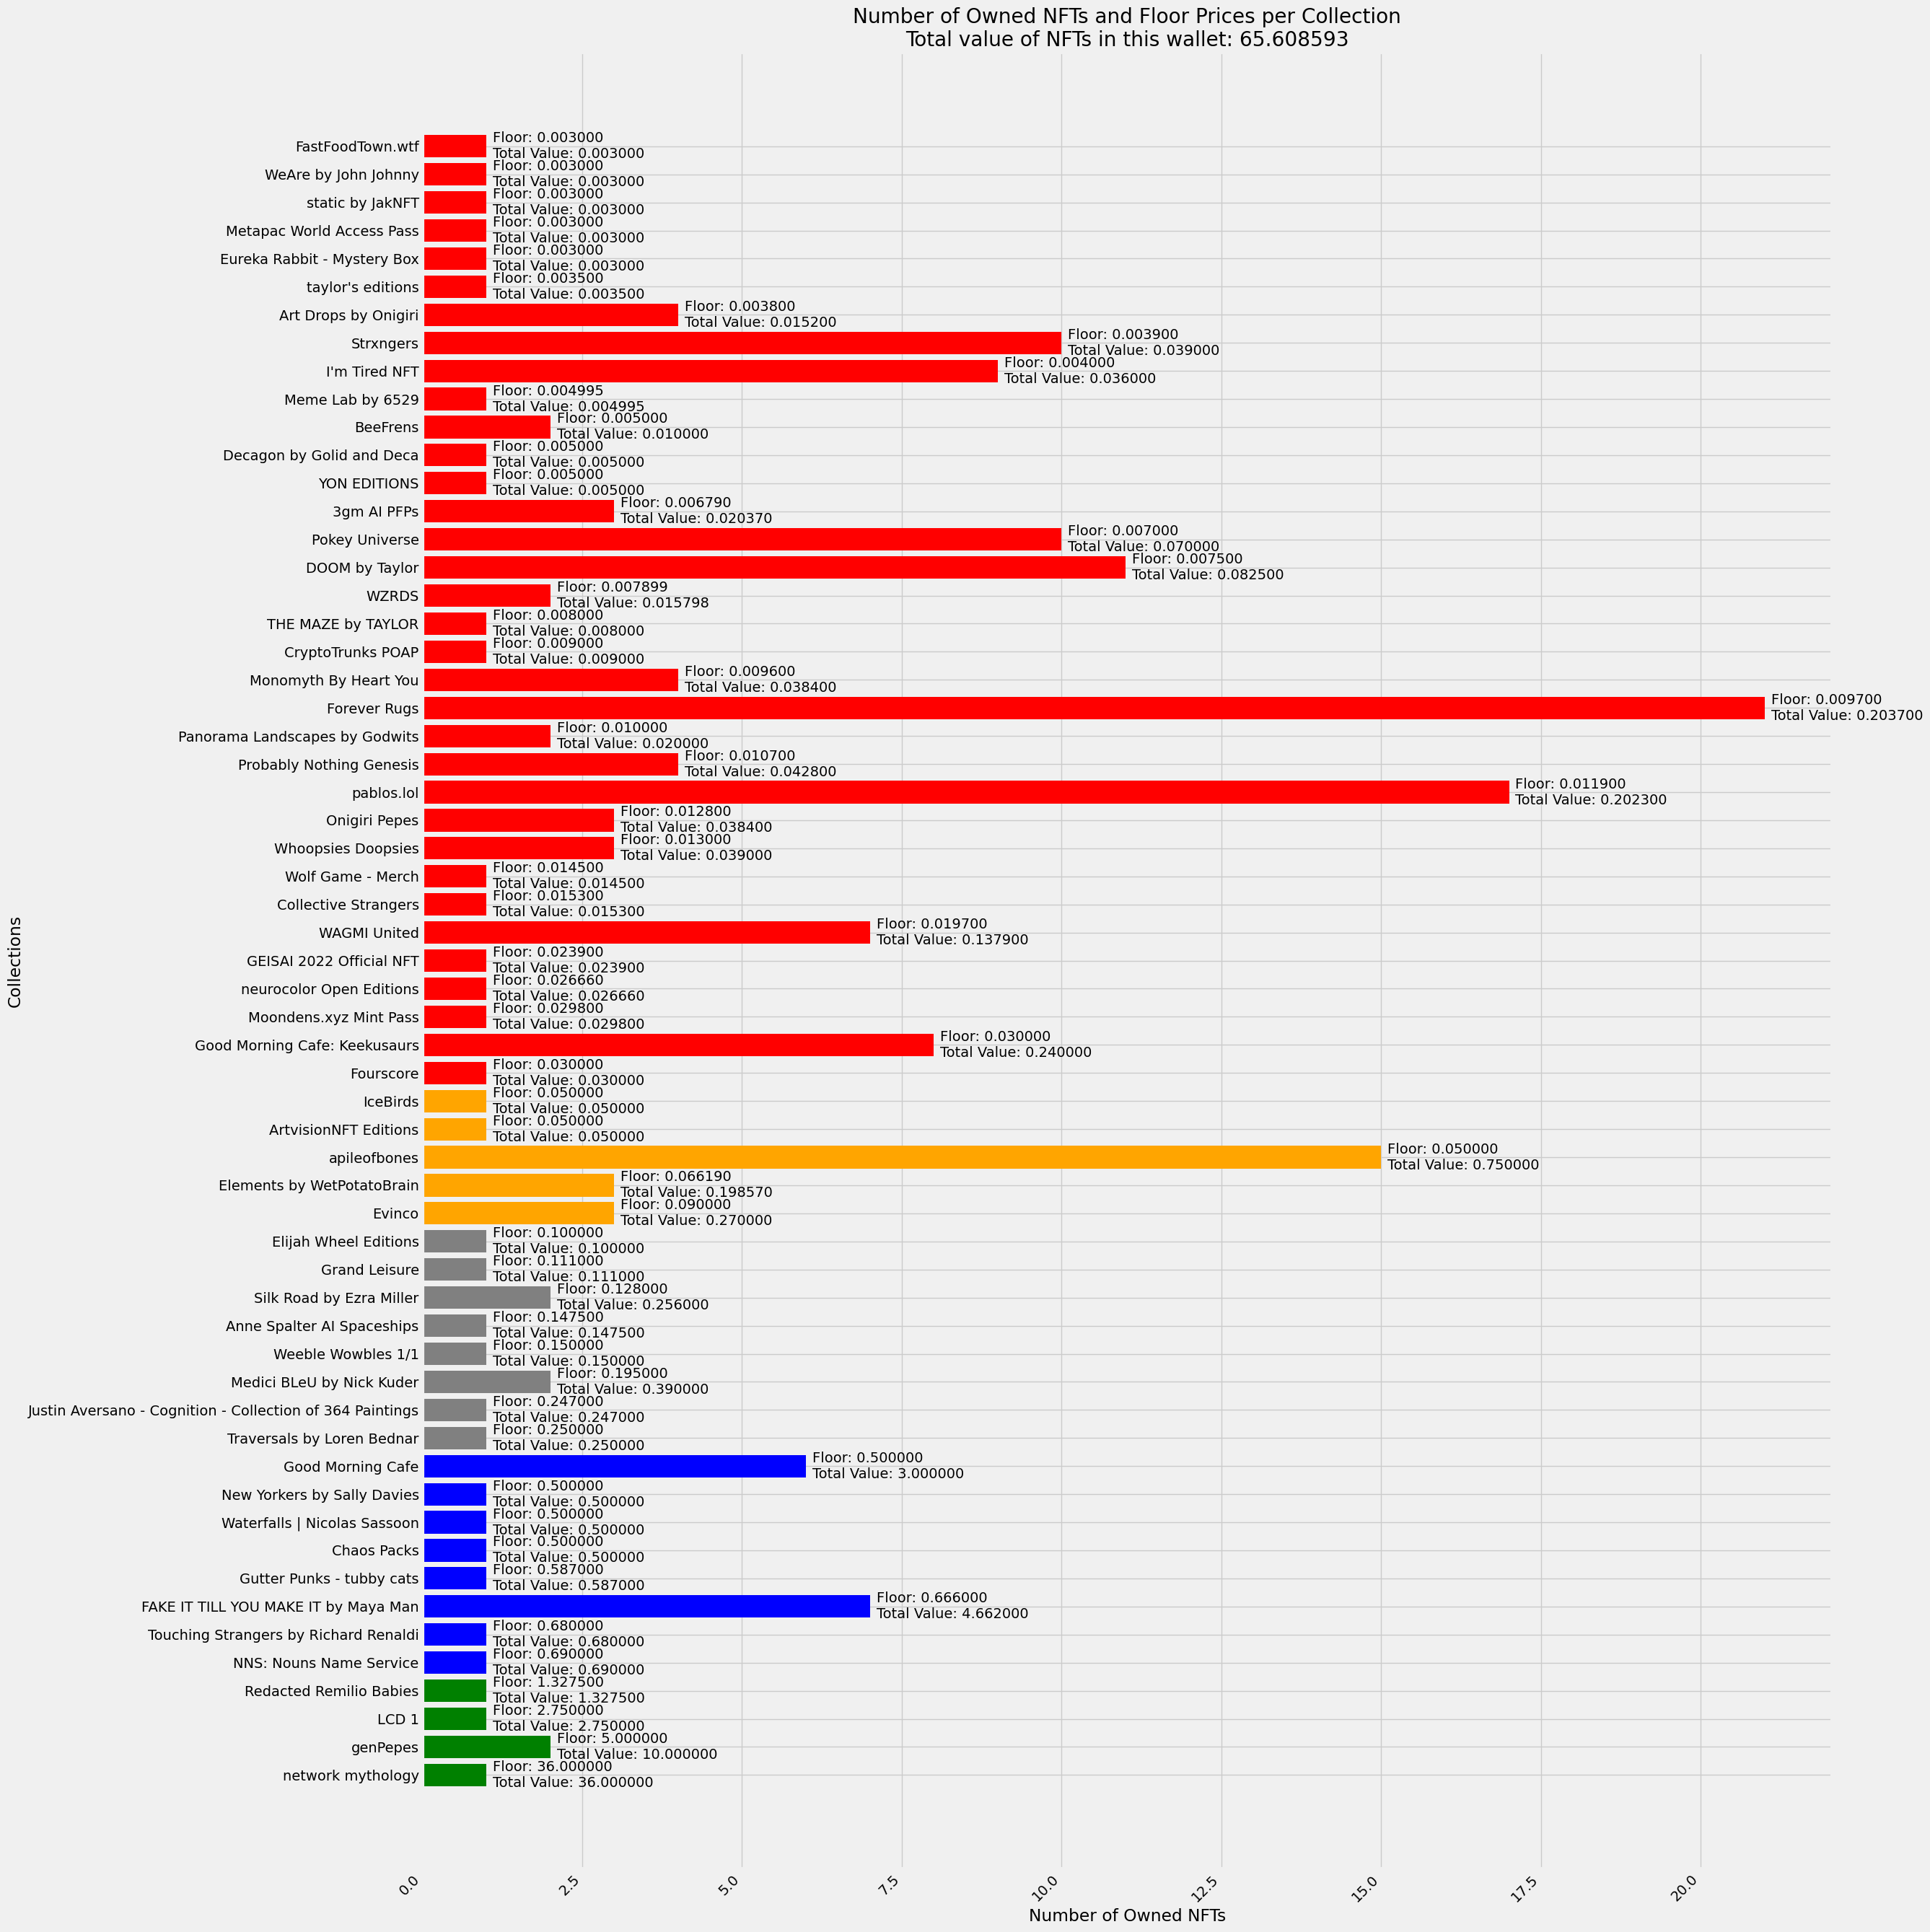

In [73]:
df_filtered_sorted = df_remove_dust.sort_values(by='Floor Price', ascending=False)

collection_names_sorted = df_filtered_sorted['Collection Name']
nft_counts_sorted = df_filtered_sorted['Number of Owned NFTs']
floor_prices_sorted = df_filtered_sorted['Floor Price']

colors = []
for floor_price in floor_prices_sorted:
    if floor_price >= 1:
        colors.append('green')
    elif floor_price >= 0.5:
        colors.append('blue')
    elif floor_price < 0.05:
        colors.append('red')
    elif floor_price >= 0.05 and floor_price < 0.1:
        colors.append('orange')
    else:
        colors.append('grey')

fig, ax = plt.subplots(figsize=(27, 27))
bars = ax.barh(collection_names_sorted, nft_counts_sorted, color=colors)

for i, bar in enumerate(bars):
    floor_price = floor_prices_sorted.iloc[i]
    total_value = df_filtered_sorted['Total Value'].iloc[i]

    if not pd.isna(floor_price):
        ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
                f"Floor: {floor_price:.6f}\nTotal Value: {total_value:.6f}", ha='left', va='center')

ax.set_xlabel('Number of Owned NFTs')
ax.set_ylabel('Collections')
ax.set_title(f'Number of Owned NFTs and Floor Prices per Collection\nTotal value of NFTs in this wallet: {total_value_wallet:.6f}')
plt.xticks(rotation=45, ha='right')

plt.subplots_adjust(left=0.25)
plt.tight_layout()
plt.show()